# Estrategias de Trading con Medias Móviles



## Introducción

En este laboratorio introductorio, creamos nuestro primer **proceso de ciencia de datos financieros**. El objetivo principal de este laboratorio es guiarlo a través del proceso general de implementación y evaluación de una estrategia de trading simple de **seguimiento de tendencias**. Para lograr esto, seguiremos los pasos distintos del proceso que se detallan a continuación:

<img align="middle" style="max-width: 600px; height: auto" src="https://github.com/financial-data-science/CFDS/blob/master/lab_03/fds_process.png?raw=1">

In [3]:
# import python utility libraries
import os as os
import datetime as dt
import itertools as it

# import python data science libraries
import pandas as pd
import numpy as np

# import the pandas financial data reader library
import pandas_datareader as dr

# import the matplotlib and seaborn visualization library
import matplotlib.pyplot as plt
import seaborn as sns

import bt as bt # library to backtest trading signals

import warnings
warnings.filterwarnings('ignore')

## Lectura de los Datos Financieros

En esta sección, utilizaremos los datos históricos diarios del mercado de valores de la corporación **"International Business Machines" (IBM)** (símbolo bursátil: "IBM"). 

In [4]:
# leer datos
path = 'data/ibm_data_1990_2017_daily.csv'
ibm_data =  pd.read_csv(path, sep="," )#.dropna()
ibm_data['Date'] = pd.to_datetime(ibm_data['Date'])
ibm_data=ibm_data.set_index('Date')#.rename(columns = {'Adj_Close':'Adj Close'})

## Preprocesar los Datos Financieros

Inspeccionar los primeros 10 registros de los datos descargados de `IBM`:

In [6]:
ibm_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-12-31,27.097275,27.127151,26.977772,27.007648,12.125891,1930079
1991-01-02,26.977772,27.186901,26.798517,26.798517,12.031993,4341737
1991-01-03,26.858271,27.216778,26.828394,26.888145,12.072238,5470162
1991-01-04,26.947897,27.007648,26.738768,26.798517,12.031993,4540058
1991-01-07,26.619265,26.738768,26.290630,26.350382,11.830786,4976450


Inspecciona visualmente el **precio de cierre ajustado** (`Adj Close`) de los datos descargados de `IBM`:

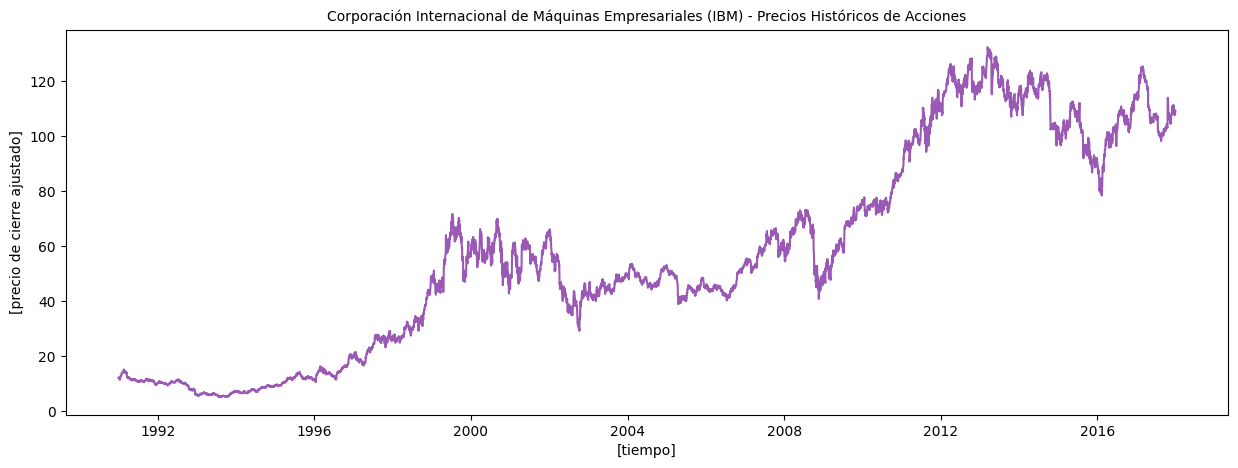

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()

# trazar los precios de cierre ajustados diarios de IBM
plt.plot(
    ibm_data.index,
    ibm_data['Adj Close'],
    color='#9b59b6'
)

# establecer etiquetas de los ejes
plt.xlabel('[tiempo]', fontsize=10)
plt.ylabel('[precio de cierre ajustado]', fontsize=10)

# establecer el título del gráfico
plt.title('Corporación Internacional de Máquinas Empresariales (IBM) - Precios Históricos de Acciones', fontsize=10);

## Análisis de Datos - Implementación de la Estrategia de Cruce de Medias Móviles

Vamos a implementar una estrategia de trading simple de **Cruce de Medias Móviles**. En general, el **trading por cruce** se refiere a la idea de que los cambios en las situaciones del mercado pueden determinarse en función de las "rupturas" de precios. Un cruce puede interpretarse como otra medida del impulso de instrumentos financieros. En el pasado, las señales de cruce han sido ampliamente utilizadas para determinar si es momento de comprar o vender el activo subyacente.

Las señales de cruce de precios de una estrategia de trading simple de **Cruce de Medias Móviles** se desencadenan por los siguientes eventos:

- Generar una señal de **venta corta** una vez que el precio de un instrumento financiero caiga por debajo de la tendencia general de precios, por ejemplo, el rango de medias móviles de 100 días ("Señal de Venta por Cruce", imagen izquierda a continuación).
- Generar una señal de **compra larga** una vez que el precio de un instrumento financiero supere la tendencia general de precios, por ejemplo, el rango de medias móviles de 100 días ("Señal de Compra por Cruce", imagen derecha a continuación). 


<img align="middle" style="max-width: 800px; height: auto" src="https://github.com/financial-data-science/CFDS/blob/master/lab_03/crossovertrading.png?raw=1">

Una mejora del **Cruce de Medias Móviles** consiste en aplicar dos medias móviles a un gráfico: una media móvil de largo plazo (por ejemplo, una SMAV de 200 días) y una media móvil de corto plazo (por ejemplo, una SMAV de 20 días). Cuando la media móvil de corto plazo cruza por encima de la media móvil de largo plazo, se activa una señal de **Compra** o **Larga**, ya que indica que la tendencia está cambiando hacia arriba (esto se conoce como "cruce dorado"). Por otro lado, cuando la media móvil de corto plazo cruza por debajo de la media móvil de largo plazo, se activa una señal de **Venta** o **Corta**, ya que indica que la tendencia está cambiando hacia abajo (esto se conoce como "cruce de muerte").

Comencemos a implementar esta estrategia de trading mejorada estableciendo los distintos tamaños de ventana de las medias móviles que especifican el número de precios de cierre ajustados diarios históricos de las acciones de IBM que se deben considerar en el cálculo de la media móvil:

In [14]:
cross_mav_days_15 = 15  # establecer "rápido" indicador de media móvil de corto plazo, ventana de observación = 15 días
cross_mav_days_60 = 60  # establecer "lento" indicador de media móvil de corto plazo, ventana de observación = 60 días
cross_mav_days_200 = 200  # establecer "tendencia" indicador de media móvil de largo plazo, ventana de observación = 200 días

Calcular las medias móviles simples de las siguientes ventanas de observación: 15 días, 50 días y 200 días. En general, la **"Media Móvil Simple (SMAV)"** de un instrumento financiero $i$ (por ejemplo, una acción, materia prima, tipo de cambio) se define como la media de los últimos $n$ precios, formalmente denotada por:


$$SMA_{i}(t)=\frac{1}{n} \sum_{k=0}^{n-1} p_{i}(t-k)$$

donde $t$ denota el punto actual en el tiempo y $n$ la ventana de observación.

Podemos calcular la SMAV utilizando simplemente las funciones `rolling()` y `mean()` de Pandas:

In [17]:
cross_mav_15 = pd.Series(ibm_data['Adj Close'].rolling(window = cross_mav_days_15).mean(), name = 'SMAV_15')
cross_mav_60 = pd.Series(ibm_data['Adj Close'].rolling(window = cross_mav_days_60).mean(), name = 'SMAV_60')
cross_mav_200 = pd.Series(ibm_data['Adj Close'].rolling(window = cross_mav_days_200).mean(), name = 'SMAV_200')

Combinar los valores de las medias móviles simples con los datos originales del mercado (precios de cierre ajustados):

In [18]:
cross_mav_ibm_data = ibm_data.join(cross_mav_15)
cross_mav_ibm_data = cross_mav_ibm_data.join(cross_mav_60)
cross_mav_ibm_data = cross_mav_ibm_data.join(cross_mav_200)

Inspeccionar y validar los precios de cierre ajustados diarios de las acciones de IBM, así como los valores derivados de las medias móviles, comenzando desde el primer precio de mercado obtenido con una media móvil de 200 días:

In [19]:
cross_mav_ibm_data[['Adj Close', 'SMAV_15', 'SMAV_60', 'SMAV_200']].iloc[200:210]

,Adj Close,SMAV_15,SMAV_60,SMAV_200
Date,,,,
1991-10-15,11.566666,11.213472,11.078775,11.863328
1991-10-16,11.275419,11.188507,11.082853,11.859545
1991-10-17,11.081260,11.151524,11.083467,11.854590
1991-10-18,11.136729,11.137655,11.085463,11.850114
1991-10-21,11.122860,11.112691,11.087227,11.846574
1991-10-22,10.928700,11.082180,11.084156,11.842734
1991-10-23,10.928700,11.062763,11.080629,11.840035
1991-10-24,10.900956,11.057216,11.077324,11.836392
1991-10-25,10.873223,11.055367,11.073558,11.832744


Graficar los precios históricos diarios de cierre ajustados de las acciones de IBM (azul), así como sus medias móviles de 15 días (verde), 60 días (rojo) y 200 días (amarillo):

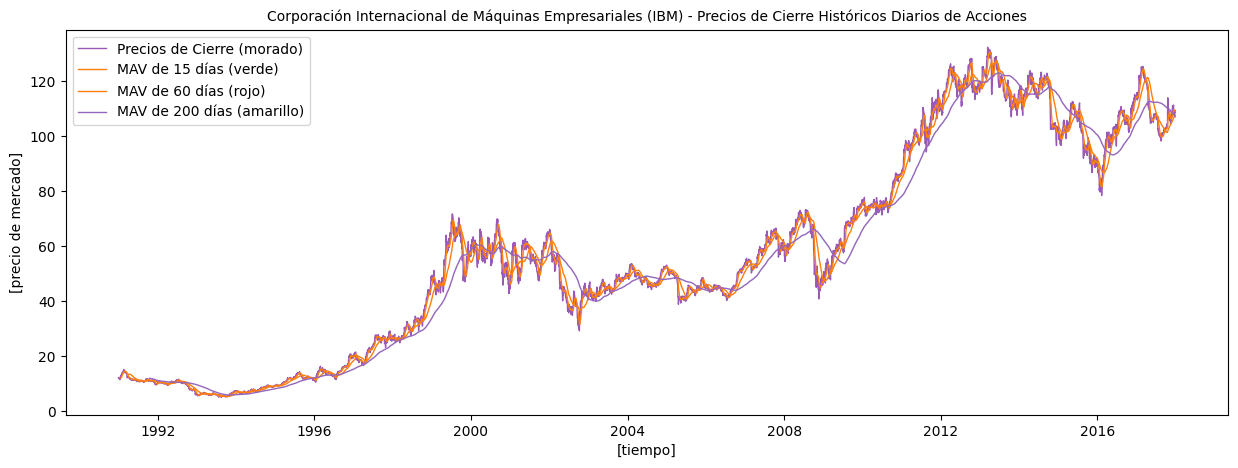

In [21]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()

# graficar precios de cierre ajustados y medias móviles
plt.plot(cross_mav_ibm_data['Adj Close'], lw=1.0, color='#9b59b6', label='Precios de Cierre (morado)')
plt.plot(cross_mav_ibm_data['SMAV_15'], color='C1',lw=1.0, label='MAV de 15 días (verde)')
plt.plot(cross_mav_ibm_data['SMAV_60'], color='C1',lw=1.0, label='MAV de 60 días (rojo)')
plt.plot(cross_mav_ibm_data['SMAV_200'], color='C4', lw=1.0, label='MAV de 200 días (amarillo)')

# establecer etiquetas de los ejes
plt.xlabel('[tiempo]', fontsize=10)
plt.ylabel('[precio de mercado]', fontsize=10)

# establecer leyenda del gráfico
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# establecer título del gráfico
plt.title('Corporación Internacional de Máquinas Empresariales (IBM) - Precios de Cierre Históricos Diarios de Acciones', fontsize=10);

## Generación de Señales de Cruce de Medias Móviles

Derivar señales de trading de dos configuraciones distintas de estrategias de cruce de medias móviles. Generaremos una **señal larga** (+1.0) para los intervalos de tiempo donde las medias móviles rápidas estén por encima de la media móvil de 200 días. Además, generaremos una **señal corta** (-1.0) para los intervalos de tiempo donde las medias móviles rápidas estén por debajo de la media móvil de 200 días:

In [24]:
# crear señales de seguimiento de tendencias 'rápidas'
cross_mav_ibm_data['SIGNAL_15'] = 0.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_15'] > cross_mav_ibm_data['SMAV_200'], 'SIGNAL_15'] = 1.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_15'] < cross_mav_ibm_data['SMAV_200'], 'SIGNAL_15'] = -1.0

# crear señales de seguimiento de tendencias 'lentas'
cross_mav_ibm_data['SIGNAL_60'] = 0.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_60'] > cross_mav_ibm_data['SMAV_200'], 'SIGNAL_60'] = 1.0
cross_mav_ibm_data.loc[cross_mav_ibm_data['SMAV_60'] < cross_mav_ibm_data['SMAV_200'], 'SIGNAL_60'] = -1.0

Además, vamos a preparar una prueba retrospectiva de un **"referencia"** en términos de una estrategia de trading **comprar y mantener** para fines de comparación. Nuestra estrategia comprar y mantener envía una señal "larga" (+1.0) para cada paso de tiempo:

In [25]:
cross_mav_ibm_data['SIGNAL_BASE'] = 1.0

Preparar los datos de las señales de trading para ser utilizados en la prueba retrospectiva de la estrategia de trading de medias móviles a largo y corto plazo:

In [26]:
# convertir las señales a un DataFrame de Pandas
cross_mav_ibm_signal_data = pd.DataFrame(cross_mav_ibm_data[['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE']], columns=['SIGNAL_15', 'SIGNAL_60', 'SIGNAL_BASE'])

# convertir el índice del DataFrame de Pandas al tipo de datos: datetime
cross_mav_ibm_signal_data = cross_mav_ibm_signal_data.set_index(pd.to_datetime(ibm_data.index))

Inspeccionar las primeras filas de las señales de trading preparadas:

In [28]:
cross_mav_ibm_signal_data.head()

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
1990-12-31,0.0,0.0,1.0
1991-01-02,0.0,0.0,1.0
1991-01-03,0.0,0.0,1.0
1991-01-04,0.0,0.0,1.0
1991-01-07,0.0,0.0,1.0


Inspeccionar algunas de las desviaciones de señal ejemplares entre las estrategias de trading de cruce de medias móviles de 15 días y 60 días:

In [29]:
cross_mav_ibm_signal_data[cross_mav_ibm_signal_data['SIGNAL_15'] != cross_mav_ibm_signal_data['SIGNAL_60']].head()

,SIGNAL_15,SIGNAL_60,SIGNAL_BASE
Date,,,
1992-05-15,1.0,-1.0,1.0
1992-05-18,1.0,-1.0,1.0
1992-05-19,1.0,-1.0,1.0
1992-05-20,1.0,-1.0,1.0
1992-05-21,1.0,-1.0,1.0


Visualizar las señales de trading preparadas:

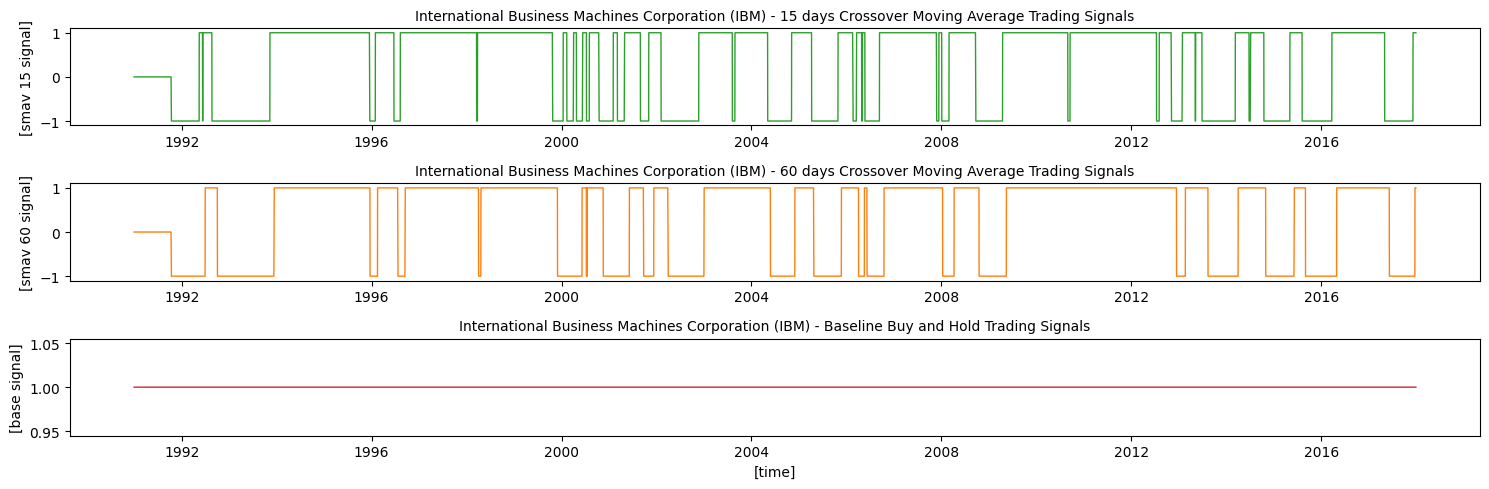

In [31]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=1, nrows=3)

ax[0].plot(cross_mav_ibm_signal_data['SIGNAL_15'], lw=1.0, color='C2', label='SMAV 16 (red)')
ax[1].plot(cross_mav_ibm_signal_data['SIGNAL_60'], lw=1.0, color='C1', label='SMAV 60 (green)')
ax[2].plot(cross_mav_ibm_signal_data['SIGNAL_BASE'], lw=1.0, color='C3', label='BASE (purple)')

# set axis labels
plt.xlabel('[time]', fontsize=10)
ax[0].set_ylabel('[smav 15 signal]', fontsize=10)
ax[1].set_ylabel('[smav 60 signal]', fontsize=10)
ax[2].set_ylabel('[base signal]', fontsize=10)


# set plot title
ax[0].set_title('International Business Machines Corporation (IBM) - 15 days Crossover Moving Average Trading Signals', fontsize=10)
ax[1].set_title('International Business Machines Corporation (IBM) - 60 days Crossover Moving Average Trading Signals', fontsize=10)
ax[2].set_title('International Business Machines Corporation (IBM) - Baseline Buy and Hold Trading Signals', fontsize=10)

# reset plot layout
plt.tight_layout()

Vamos a determinar el número total de **cambios de señal larga-corta** de las distintas estrategias de trading:

In [32]:
# cambios de señal de la estrategia de trading de cruce de medias móviles de 15-200 días
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_15'], lambda x: x > 0)))

64

In [33]:
# cambios de señal de la estrategia de trading de cruce de medias móviles de 60-200 días
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_60'], lambda x: x > 0)))

44

In [34]:
# cambios de señal de la estrategia de trading de comprar y mantener como referencia
len(list(it.groupby(cross_mav_ibm_signal_data['SIGNAL_BASE'], lambda x: x > 0)))

1

## Backtest - Señal de Cruce de Medias Móviles

Preparar los datos de mercado para utilizar *backtesting* de las configuraciones de estrategia de trading de cruce de medias móviles:







In [36]:
# extraer los precios de cierre de las acciones de IBM
ibm_market_data = pd.DataFrame(ibm_data['Adj Close'], columns=['Adj Close'])

# renombrar la columna 'close' a 'ibm' (ya que esta es la columna que queremos asignar el Backtest)
ibm_market_data = ibm_market_data.rename(columns={'Adj Close': 'IBM'})

# convertir el índice del DataFrame de Pandas al tipo de datos: datetime
ibm_market_data = ibm_market_data.set_index(pd.to_datetime(ibm_data.index))

Inspeccionar las primeras filas de los datos de mercado preparados:

In [37]:
ibm_market_data.head()

,IBM
Date,
1990-12-31,12.125891
1991-01-02,12.031993
1991-01-03,12.072238
1991-01-04,12.031993
1991-01-07,11.830786


Implementar una estrategia de trading simple de medias móviles mediante la interfaz de la clase Algo de Python `bt`:

In [38]:
class MovingAverageStrategy(bt.Algo):

    # inits the strategy
    def __init__(self, signals):

        # set class signals
        self.signals = signals

    # calss the trading strategy
    def __call__(self, target):

        # case: current timestep in signals
        if target.now in self.signals.index[1:]:

            # get actual signal
            signal = self.signals[target.now]

            # set target weights according to signal
            target.temp['weights'] = dict(IBM=signal)

        # return 'True' since we want to move on to the next timestep
        return True

Definir el stack de algoritmos para el backtest de la estrategia de trading de medias móviles.

**Nota:** En la biblioteca Python `bt`, una estrategia de trading generalmente consiste en una **stack de algoritmos**. Para cada paso de tiempo de nuestro marco del backtest, la biblioteca `bt` ejecuta todos los algoritmos en orden secuencial. Cada estrategia de medias móviles que pretendemos diseñar y probar consiste en total de tres algoritmos, brevemente descritos a continuación:

> 1. `bt.algos.SelectAll()`: Selecciona todas las acciones disponibles para trading excepto los precios de las acciones que corresponden a NaN o 0.00.
> 2. `MovingAverageStrategy()`: Asigna la señal calculada en términos de un valor de peso a las acciones de IBM.
> 3. `bt.algos.Rebalance()`: Rebalancea el capital disponible en función de los pesos asignados a cada acción.

Definir la stack de algoritmos para el backtest de la estrategia de trading de medias móviles a largo y corto plazo:

In [39]:
cross_mav_ibm_strategy_15 = bt.Strategy(name='smav_15', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_15']), bt.algos.Rebalance()])
cross_mav_ibm_strategy_60 = bt.Strategy(name='smav_60', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_60']), bt.algos.Rebalance()])
cross_mav_ibm_strategy_base = bt.Strategy(name='base', algos=[bt.algos.SelectAll(), MovingAverageStrategy(cross_mav_ibm_signal_data['SIGNAL_BASE']), bt.algos.Rebalance()])

Ahora definamos las comisiones de trading ('tarifas') utilizadas en cada paso de rebalanceo de un backtest. Para lograr esto, la biblioteca `bt` toma una función que espera los siguientes dos parámetros como entrada:

> - la 'cantidad', denominada `q`, de activos rebalanceados en un paso de tiempo de prueba retrospectiva;
> - el 'precio', denominado `p`, de los activos rebalanceados en un paso de tiempo de prueba retrospectiva.

Implementemos una función invocable de este tipo que defina una tarifa de trading del **1\% (0.01)** por cantidad de activo rebalanceado (o una tarifa plana de **USD 5.00** por operación):

In [40]:
# init trading fees function
def trading_fees_function(q, p):

    # calcluate trading fees (rebalanced-quantity * trading-fee)
    fees = q * 0.01 # non-flat fee of 1% per quantity of rebalanced asset
    # fees = 5.00 # flat fee of USD 5.00 per trade

    # return the total trading fees
    return fees

Una vez completada la definición de las estrategias de medias móviles a largo y corto plazo, procedamos a iniciar los backtest correspondientes utilizando (1) ambas estrategias, así como (2) los datos de mercado que queremos evaluar durante backtestel backtest:

In [41]:
ibm_backtest_cross_mav_15 = bt.Backtest(strategy=cross_mav_ibm_strategy_15, data=ibm_market_data, name='ibm_backtest_smav_15', commissions=trading_fees_function, progress_bar=True)
ibm_backtest_cross_mav_60 = bt.Backtest(strategy=cross_mav_ibm_strategy_60, data=ibm_market_data, name='ibm_backtest_smav_60', commissions=trading_fees_function, progress_bar=True)
ibm_backtest_cross_mav_base = bt.Backtest(strategy=cross_mav_ibm_strategy_base, data=ibm_market_data, name='ibm_backtest_smav_base', commissions=trading_fees_function, progress_bar=True)

Ahora, ejecutemos el backtest de ambas configuraciones de la estrategia de cruce de medias móviles, así como la referencia definida:

In [42]:
backtest_results_ibm = bt.run(ibm_backtest_cross_mav_15, ibm_backtest_cross_mav_60, ibm_backtest_cross_mav_base)

ibm_backtest_smav_15
0% [############################# ] 100% | ETA: 00:00:00ibm_backtest_smav_60
0% [############################# ] 100% | ETA: 00:00:00ibm_backtest_smav_base
0% [############################# ] 100% | ETA: 00:00:00

Inspeccionar los resultados individuales del backtest y las medidas de rendimiento:

In [43]:
backtest_results_ibm.display()

Stat                 ibm_backtest_smav_15    ibm_backtest_smav_60    ibm_backtest_smav_base
-------------------  ----------------------  ----------------------  ------------------------
Start                1990-12-30              1990-12-30              1990-12-30
End                  2017-12-29              2017-12-29              2017-12-29
Risk-free rate       0.00%                   0.00%                   0.00%

Total Return         35.24%                  -83.46%                 804.82%
Daily Sharpe         0.18                    -0.10                   0.43
Daily Sortino        0.28                    -0.16                   0.73
CAGR                 1.12%                   -6.45%                  8.50%
Max Drawdown         -86.02%                 -94.10%                 -66.83%
Calmar Ratio         0.01                    -0.07                   0.13

MTD                  0.12%                   1.45%                   -0.36%
3m                   -7.55%                  -6.32

Recopilar el rendimiento detallado del backtest por paso de tiempo de la estrategia de cruce de medias móviles "rápida" de **15-200 días**:

In [44]:
backtest_sma_15_ibm_details = ibm_backtest_cross_mav_15.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_15_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_15.strategy.values # equity per timestep
backtest_sma_15_ibm_details['CASH'] = ibm_backtest_cross_mav_15.strategy.cash # cash per timestep
backtest_sma_15_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_15.strategy.positions # positions per timestep
backtest_sma_15_ibm_details['FEES'] = ibm_backtest_cross_mav_15.strategy.fees # trading fees per timestep

Inspeccionar los resultados detallados del backtest por paso de tiempo:

In [45]:
backtest_sma_15_ibm_details.head()

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30,100.0,1000000.0,1000000.0,0.0,0.0
1990-12-31,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-02,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-03,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-04,100.0,1000000.0,1000000.0,0.0,0.0


Visualizar los rendimientos mensuales obtenidos por la estrategia de cruce de medias móviles de **15-200 días**:

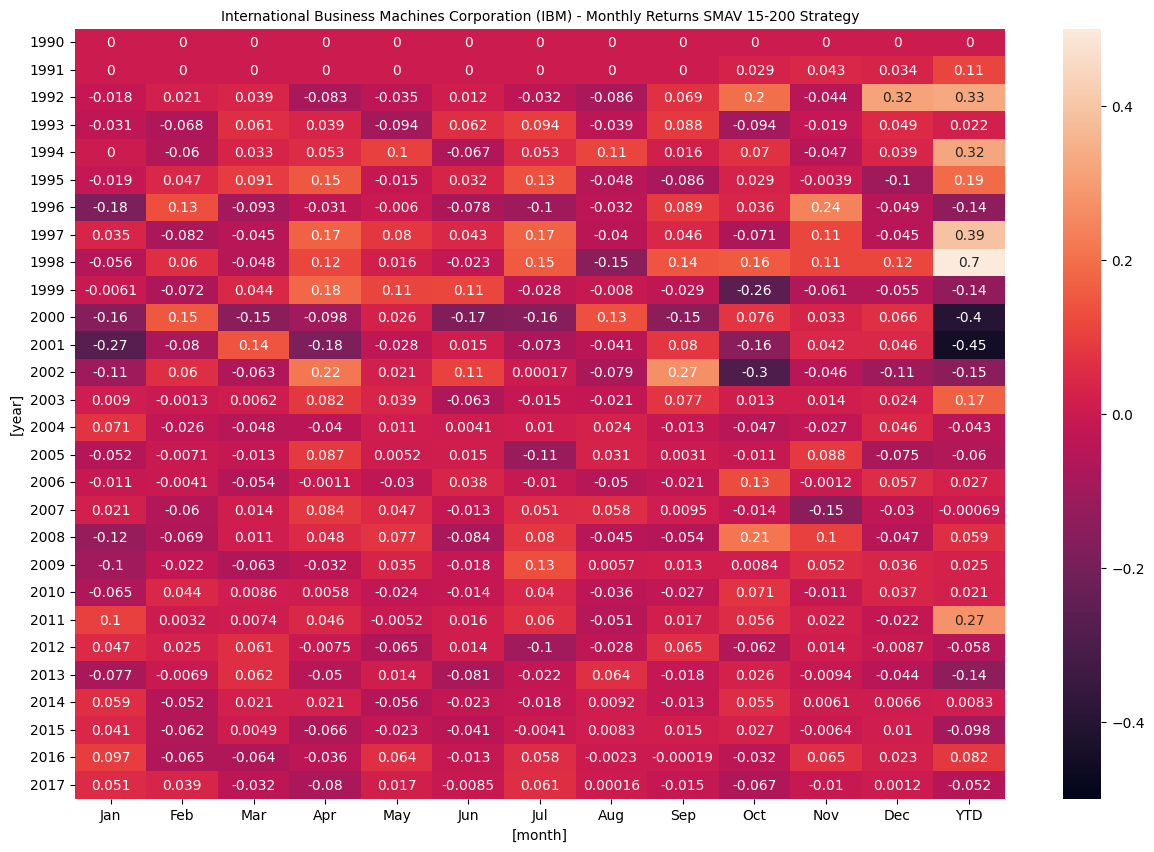

In [46]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_15.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV 15-200 Strategy', fontsize=10);

Recopilar el rendimiento detallado del backtest por paso de tiempo de la estrategia de cruce de medias móviles "lenta" de **60-200 días**:

In [47]:
backtest_sma_60_ibm_details = ibm_backtest_cross_mav_60.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_60_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_60.strategy.values # equity per timestep
backtest_sma_60_ibm_details['CASH'] = ibm_backtest_cross_mav_60.strategy.cash # cash per timestep
backtest_sma_60_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_60.strategy.positions # positions per timestep
backtest_sma_60_ibm_details['FEES'] = ibm_backtest_cross_mav_60.strategy.fees # fees per timestep

Inspeccionar los resultados detallados de la prueba retrospectiva por paso de tiempo:

In [48]:
backtest_sma_60_ibm_details.head()

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30,100.0,1000000.0,1000000.0,0.0,0.0
1990-12-31,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-02,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-03,100.0,1000000.0,1000000.0,0.0,0.0
1991-01-04,100.0,1000000.0,1000000.0,0.0,0.0


Visualizar los rendimientos mensuales obtenidos por la estrategia de cruce de medias móviles de **60-200 días**:

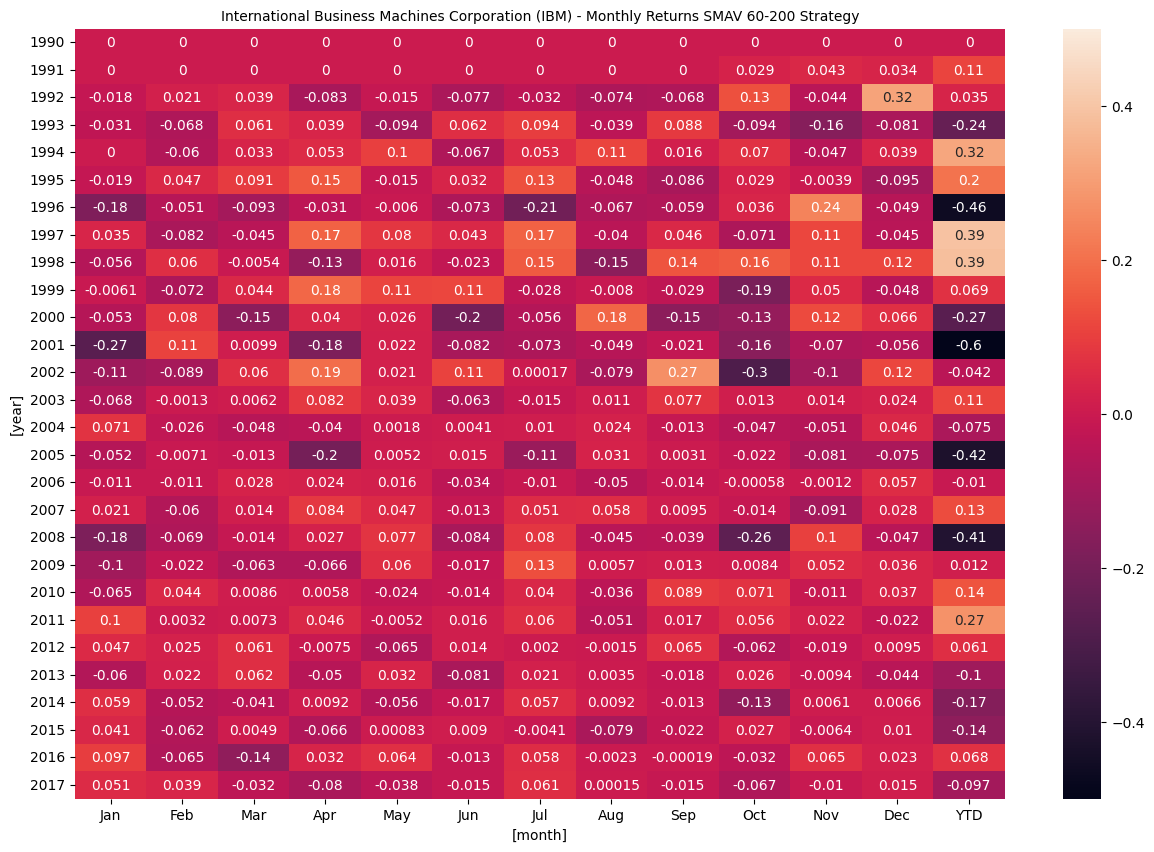

In [49]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_60.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV 60-200 Strategy', fontsize=10);

Recopilar el rendimiento detalladodel backtest por paso de tiempo de la estrategia de referencia "solo largo":

In [51]:
backtest_sma_base_ibm_details = ibm_backtest_cross_mav_base.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_sma_base_ibm_details['Abs. EQUITY'] = ibm_backtest_cross_mav_base.strategy.values # equity per timestep
backtest_sma_base_ibm_details['CASH'] = ibm_backtest_cross_mav_base.strategy.cash # cash per timestep
backtest_sma_base_ibm_details['POSITIONS'] = ibm_backtest_cross_mav_base.strategy.positions # positions per timestep
backtest_sma_base_ibm_details['FEES'] = ibm_backtest_cross_mav_base.strategy.fees # fees per timestep

Inspeccionar los resultados detallados del backtest por paso de tiempo:

In [52]:
backtest_sma_base_ibm_details.head()

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
1990-12-30,100.000000,1.000000e+06,1000000.000000,0.0,0.00
1990-12-31,100.000000,1.000000e+06,1000000.000000,0.0,0.00
1991-01-02,99.916958,9.991696e+05,8.824577,83042.0,830.42
1991-01-03,100.251161,1.002512e+06,8.824577,83042.0,0.00
1991-01-04,99.916958,9.991696e+05,8.824577,83042.0,0.00


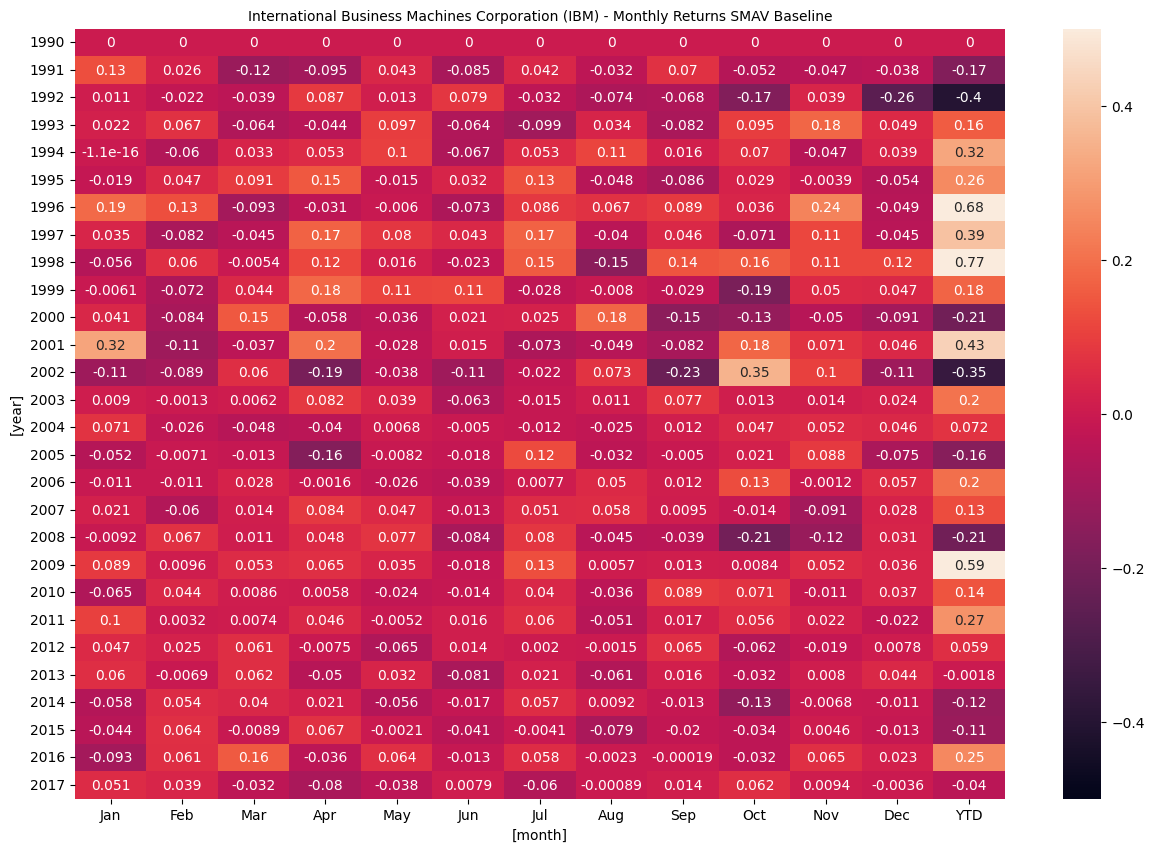

In [53]:
plt.rcParams['figure.figsize'] = [15, 10]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(ibm_backtest_cross_mav_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns SMAV Baseline', fontsize=10);

Visualizar la progresión de la equidad de cada estrategia en el backtest a lo largo del tiempo:

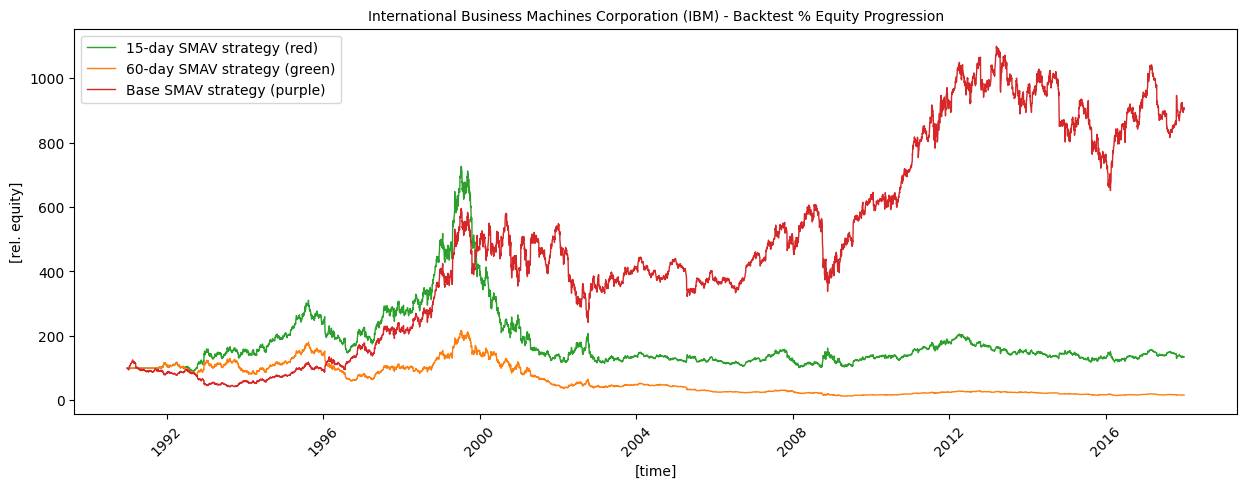

In [55]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot equity progression of the distinct trading strategies
ax.plot(backtest_sma_15_ibm_details['Rel. EQUITY'], color='C2',lw=1.0, label='15-day SMAV strategy (red)')
ax.plot(backtest_sma_60_ibm_details['Rel. EQUITY'], color='C1',lw=1.0, label='60-day SMAV strategy (green)')
ax.plot(backtest_sma_base_ibm_details['Rel. EQUITY'], color='C3',lw=1.0, label='Base SMAV strategy (purple)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([start_date, end_date])
ax.set_ylabel('[rel. equity]', fontsize=10)

# set plot legend
plt.legend(loc="upper left", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Backtest % Equity Progression', fontsize=10);

## Ejercicios


**1. Evaluación de distintos parámetros de medias móviles diarias.**

> Evaluar la estrategia de trading simple de cruce de medias móviles utilizando distintas ventanas de observación de medias móviles, por ejemplo, 10 días, 30 días, 50 días, 200 días y 300 días. Comparar el rendimiento de las parametrizaciones de ventana de observación en términos de rendimiento total, progresión de la equidad y ratio de Sharpe anual. Obtener una intuición sobre los años en los que la estrategia no funcionó bien y la posible razón de su bajo rendimiento.

In [61]:
# Calcular medias móviles diarias
ibm_market_data['MA_10'] = ibm_market_data['IBM'].rolling(window=10).mean()
ibm_market_data['MA_30'] = ibm_market_data['IBM'].rolling(window=30).mean()
ibm_market_data['MA_50'] = ibm_market_data['IBM'].rolling(window=50).mean()
ibm_market_data['MA_200'] = ibm_market_data['IBM'].rolling(window=200).mean()
ibm_market_data['MA_300'] = ibm_market_data['IBM'].rolling(window=300).mean()

In [63]:
# Implementar la estrategia de cruce de medias móviles
def moving_average_crossover_strategy(data):
    signals = pd.DataFrame(index=data.index)
    signals['Signal'] = 0.0
    signals['MA_10'] = data['MA_10']
    signals['MA_200'] = data['MA_200']
    signals['Signal'][10:] = np.where(data['MA_10'][10:] > data['MA_200'][10:], 1.0, 0.0)   
    signals['Positions'] = signals['Signal'].diff()
    return signals

# Aplicar la estrategia de cruce de medias móviles a cada ventana de observación
signals_10_200 = moving_average_crossover_strategy(ibm_market_data[['MA_10', 'MA_200']])
signals_30_200 = moving_average_crossover_strategy(ibm_market_data[['MA_30', 'MA_200']])
signals_50_200 = moving_average_crossover_strategy(ibm_market_data[['MA_50', 'MA_200']])
signals_300_200 = moving_average_crossover_strategy(ibm_market_data[['MA_300', 'MA_200']])

# Calcular el rendimiento total para cada estrategia
def calculate_total_return(signals, data):
    positions = signals['Positions']
    returns = data['Adj Close'].pct_change()
    total_return = (positions.shift(-1) * returns).sum()
    return total_return

total_return_10_200 = calculate_total_return(signals_10_200, ibm_market_data)
total_return_30_200 = calculate_total_return(signals_30_200, ibm_market_data)
total_return_50_200 = calculate_total_return(signals_50_200, ibm_market_data)
total_return_300_200 = calculate_total_return(signals_300_200, ibm_market_data)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(ibm_market_data['Date'], ibm_market_data['Adj Close'], label='Precio de Cierre Ajustado', color='black')
plt.plot(ibm_market_data['Date'], ibm_market_data['MA_10'], label='MA 10', color='red')
plt.plot(ibm_market_data['Date'], ibm_market_data['MA_200'], label='MA 200', color='blue')
plt.scatter(signals_10_200.index, ibm_market_data['MA_10'][signals_10_200['Positions'] == 1.0], marker='^', color='g', label='Compra')
plt.scatter(signals_10_200.index, ibm_market_data['MA_200'][signals_10_200['Positions'] == -1.0], marker='v', color='r', label='Venta')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Precio de Cierre Ajustado y Medias Móviles')
plt.legend()
plt.show()

print("Rendimiento total para MA 10-200:", total_return_10_200)
print("Rendimiento total para MA 30-200:", total_return_30_200)
print("Rendimiento total para MA 50-200:", total_return_50_200)
print("Rendimiento total para MA 300-200:", total_return_300_200)

KeyError: 'MA_10'